# Particle filtering

In this tutorial we explain how to use `ProbNum` for particle filtering.
We assume that you have read the tutorial on non-linear filtering.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probnum import filtsmooth, random_variables, statespace, diffeq
from scipy import stats

In [2]:
np.random.seed(12345)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

# Consistent plotting styles for particles and for "true" latent states
particle_style = {
    "color": "C1",
    "marker": "o",
    "markersize": 5,
    "linestyle": "None",
    "alpha": 0.5,
}
latent_state_style = {"color": "C0", "linewidth": 4, "linestyle": "-", "alpha": 0.5}

## Pendulum

We begin with setting up the pendulum problem, which is a standard non-linear test problem. The code below is taken from the non-linear filtering notebook.

We begin by assembling a `DiscreteGaussian` as a model of the prior dynamics.

In [4]:
state_dim = 2
observation_dim = 1

# approx. gravitational constant
g = 9.81
delta_t = 0.05


def pendulum_rhs(state):
    """Right-hand side of an ODE that defines pendulum dynamics"""
    x1, x2 = state
    y1 = x1 + x2 * delta_t
    y2 = x2 - g * np.sin(x1) * delta_t
    return np.array([y1, y2])


def pendulum_jacobian(state):
    """Jacobian of the pendulum ODE"""
    x1, x2 = state
    dy1_dx = [1.0, delta_t]
    dy2_dx = [-g * np.cos(x1) * delta_t, 1.0]
    return np.array([dy1_dx, dy2_dx])


dynamics_transition_function = lambda t, state: pendulum_rhs(state)
dynamics_transition_jacobian_function = lambda t, state: pendulum_jacobian(state)

dynamics_diffusion_matrix = 1.0 * (
    np.diag(np.array([delta_t ** 3 / 3, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2]), 1)
    + np.diag(np.array([delta_t ** 2 / 2]), -1)
)

# Create discrete, non-linear Gaussian dynamics model
dynamics_model = statespace.DiscreteGaussian(
    input_dim=state_dim,
    output_dim=state_dim,
    state_trans_fun=dynamics_transition_function,
    proc_noise_cov_mat_fun=lambda t: dynamics_diffusion_matrix,
    jacob_state_trans_fun=dynamics_transition_jacobian_function,
)

Next, we set up the measurement model as another discrete, non-linear Gaussian transformation.

In [5]:
def pendulum_measurement(state):
    x1, x2 = state
    return np.array([np.sin(x1)])


def pendulum_measurement_jacobian(state):
    x1, x2 = state
    return np.array([[np.cos(x1), 0.0]])


measurement_function = lambda t, state: pendulum_measurement(state)
measurement_jacobian_function = lambda t, state: pendulum_measurement_jacobian(state)

measurement_variance = 0.12 ** 2
measurement_covariance = measurement_variance * np.eye(observation_dim)

# Create discrete, non-linear Gaussian measurement model
measurement_model = statespace.DiscreteGaussian(
    input_dim=state_dim,
    output_dim=observation_dim,
    state_trans_fun=measurement_function,
    proc_noise_cov_mat_fun=lambda t: measurement_covariance,
    jacob_state_trans_fun=measurement_jacobian_function,
)

Finally, we define the initial distribution: a Gaussian random variable. We also generate some artificial observations.

In [6]:
mu_0 = np.ones(state_dim)
sigma_0 = measurement_variance * np.eye(state_dim)
initial_state_rv = random_variables.Normal(mean=mu_0, cov=sigma_0)

In [7]:
time_grid = np.arange(0.0, 3.5, step=delta_t)
latent_states, observations = statespace.generate_samples(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid,
)

Now we're essentially good to go. With this setup we could do non-linear Gaussian filtering (extended Kalman filtering, unscented Kalman filtering), but here, we avoid the Gaussian approximations and do particle filtering.

To construct a particle filter, we provide prior, measurement model, and initial RV as well as

* The number of particles: `num_particles`. The larger the better, but also the larger the slower (it is Monte Carlo approximation, after all).
* A linearized measurement model that is used as an importance density: `linearized_measurement_model`. In ProbNum we implement two types of particle filters: a bootstrap particle filter, that uses the prior as an importance distribution (which always works, but also requires a lot of particles -- this is what is used in `linearized_measurement_model` is left empty), and a particle filter that uses an approximate Gaussian filter as an importance density. In the pendulum example, we do the latter, because the extended Kalman filter has already been proven to be successful.

In [8]:
# Importance density: EKF
linearized_measurement_model = filtsmooth.DiscreteEKFComponent(measurement_model)
num_particles = 10

# Construct the PF
pf = filtsmooth.ParticleFilter(
    dynamics_model,
    measurement_model,
    initrv=initial_state_rv,
    num_particles=num_particles,
    linearized_measurement_model=linearized_measurement_model,
)

The remainder is the same `.filter()` interface that we know from Gaussian filtering.
After applying this method, we plot the mode of the posterior distribution.

In [9]:
posterior = pf.filter(observations, time_grid)

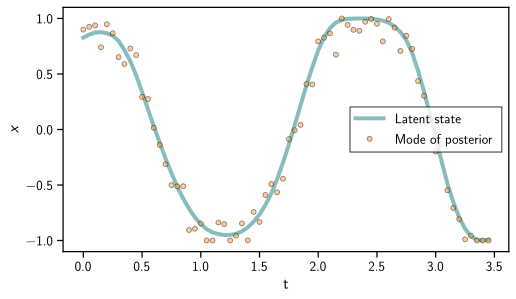

In [10]:
plt.plot(time_grid, np.sin(latent_states[:, 0]), **latent_state_style, label="Latent state")
plt.plot(time_grid, np.sin(posterior.states.mode[ :, 0]), **particle_style, label="Mode of posterior")
plt.xlabel("t")
plt.ylabel(r"$x$")
plt.legend()

plt.show()

It seems that the true latent state is recovered fairly well.
The RMSE of the mode is also much smaller than the RMSE of the data:

In [11]:
rmse_mode = np.linalg.norm(np.sin(posterior.states.mode[:, 0]) - np.sin(latent_states[:, 0]))
rmse_data = np.linalg.norm(observations - np.sin(latent_states[:, 0]))
print(f"Mode of PF: \t{rmse_mode}\nObservations: \t{rmse_data}")

Mode of PF: 	0.8055239284009064
Observations: 	75.1458375474807


The strength of a particle filter is not the point estimate, but the posterior distribution. Let us look at a few more particles; more precisely, those that have probability larger than the mean probability of the current particle set (in other words, those that are more likely than the average value)

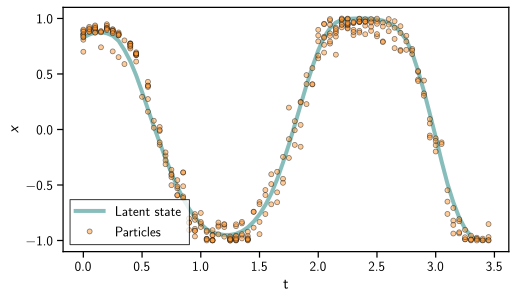

In [12]:
# Plot the important particles
plt.plot(time_grid, np.sin(latent_states[:, 0]), **latent_state_style, label="Latent state")

for t, state in zip(time_grid, posterior.states):
    important_states = state.support[
        state.probabilities > 0.9 * state.probabilities.mean()
    ]
    plt.plot(t, np.sin(important_states[:, 0]).reshape((1, -1)), **particle_style, label="Particles")

plt.xlabel("t")
plt.ylabel(r"$x$")

# Remove duplicate legend entries before showing the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

It seems that the distribution nicely concentrates around the true state.

## ODEs

Particle filters can also be used to solve ODEs (in a very basic way -- if you need a reliant method, use the ODE solvers in `diffeq` instead).

Let us consider a Bernoulli equation,
$$
\dot y(t) = 1.5 (y - y^3), \quad y(0) \approx 0,
$$

which has two stable equilibria: one at $\pm 1$ each, which are reached depending on the sign of the initial value. There is also an unstable equilibrium at $0.$.

We begin by setting up this ODE in the language of `probnum.diffeq`.

In [43]:
def bern_rhs(t, x):
    return 1.5 * (x - x ** 3)


def bern_jac(t, x):
    return np.array([1.5 * (1 - 3 * x ** 2)])


t0, tmax = 0.0, 6.0
initrv = random_variables.Constant(np.array([0.0]))
bernoulli = diffeq.IVP([t0, tmax], initrv, rhs=bern_rhs, jac=bern_jac)

We will not go into detail about how to turn an ODE into a filtering problem, but in a nutshell: you need a `statespace.Integrator` prior, and a measurement model that "punishes" the discrepancy of the ODE $\dot y - f(y)$. We construct both. As an initial random variable we choose a Gaussian random variable (whose dimension must match the dimension of the prior, not of the ODE!). We add a bit of "evaluation variance" (`evlvar`), because the particle filter struggles with noise-free observations.

In [44]:
dynamod = statespace.IBM(ordint=2, spatialdim=1, forward_implementation="sqrt")
measmod = statespace.DiscreteGaussian.from_ode(bernoulli, dynamod, evlvar=0.00001)

initmean = np.array([0.0, 0, 0.0])
initcov = 0.0125 * np.diag([1, 1.0, 1.0])
initrv = random_variables.Normal(initmean, initcov, cov_cholesky=np.sqrt(initcov))

As in the pendulum example, we use an extended Kalman filter importance distribution.

In [45]:
linearised_measmod = filtsmooth.DiscreteEKFComponent(
    measmod, backward_implementation="sqrt"
)
num_particles = 20
ode_pf = filtsmooth.ParticleFilter(
    dynamod,
    measmod,
    initrv,
    num_particles=num_particles,
    linearized_measurement_model=linearised_measmod,
)

The ODE filtering problem consists of evenly spaced points and data that is equal to zero. The rest is `ParticleFilter.filter()`.

In [46]:
num_locs = 50
data = np.zeros((num_locs, 1))
locs = np.linspace(0.0, tmax, num_locs)
posterior = ode_pf.filter(dataset=data, times=locs)

We plot the entire set of particles.

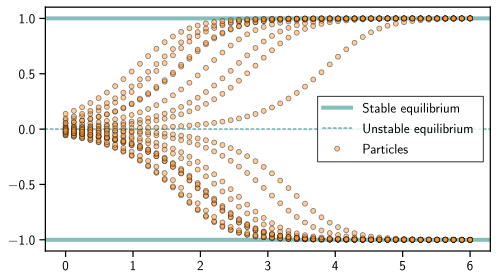

In [48]:
plt.axhline(+1, **latent_state_style, label="Stable equilibrium")
plt.axhline(0., linestyle="dotted", alpha=0.5, label="Unstable equilibrium")
plt.axhline(-1, **latent_state_style)
plt.plot(locs, posterior.states.support[:, :, 0], **particle_style, label="Particles")

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

Depending on the position of the initial particle (which is a sample from the initial random variable), the trajectories either approach +1 or -1. Eventually, they all get there.

## Summary

Particle filtering seamlessly blends into the filtering and smoothing code in ProbNum. It can be constructed with the same ingredients as a Gaussian filter, but of course there are fewer restrictions on tractability in those models (any non-linear discrete model works well).
Choices are the bootstrap filter (if `linearized_measurement_model` is left empty) or one with a Gaussian filter used as an importance density (if e.g. `DiscreteUKFComponent` or `DiscreteEKFComponent`) are provided.

Its results infer the true latent states well on simple problems, and the family of particles displays differnet paths of the potential solution (which is especially evident in the ODE example).